In [1]:
## Importing Libraries

import os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from PIL import Image

print(tf.__version__)

tf.set_random_seed(777)

1.12.0


In [2]:
## training에 사용할 image size
img_width = 224
img_height = 224

In [3]:
## tfrecord file 이름과 디렉토리 설정
tfrecord_train = 'train.tfrecord'
tfrecord_test = 'test.tfrecord'
tfrecord_dir = 'tfrecords'

In [4]:
## tfrecord file 경로 설정
cur_dir = os.getcwd()
train_tfr_path = os.path.join(cur_dir, tfrecord_dir, tfrecord_train)
test_tfr_path = os.path.join(cur_dir, tfrecord_dir, tfrecord_test)

In [5]:
## hyper parameters
learning_rate = 0.001
training_epochs = 20
batch_size = 10

## class 갯수
n_class = 10
## training data 수
n_train = 5000
## test data 수
n_test = 1000
## learning rate decay ratio
lr_decay_ratio = 0.1
## 몇 epoch 마다 learning rate을 decay할 것인지
lr_decay_epoch_num = 10
## image file 위치
image_dir = 'korean_food_10'

In [6]:
def _parse_function(tfrecord_serialized):
    features={'image': tf.FixedLenFeature([], tf.string),
             'label': tf.FixedLenFeature([], tf.int64)}
    parsed_features = tf.parse_single_example(tfrecord_serialized, features)
    
    image = tf.decode_raw(parsed_features['image'], tf.uint8)
    label = tf.cast(parsed_features['label'], tf.int32)
    #label_onehot = tf.one_hot(label, depth=n_class)
        
    #image = tf.reshape(image, [-1, img_height, img_width, 3])
    
    return image, label

In [7]:
train_dataset = tf.data.TFRecordDataset(train_tfr_path)
train_dataset = train_dataset.map(_parse_function, num_parallel_calls=8)
train_dataset = train_dataset.shuffle(buffer_size=n_train*2).prefetch(
    buffer_size=batch_size).batch(batch_size).repeat()

In [8]:
test_dataset = tf.data.TFRecordDataset(test_tfr_path)
test_dataset = test_dataset.map(_parse_function, num_parallel_calls=8)
test_dataset = test_dataset.shuffle(buffer_size=n_train*2).prefetch(
    buffer_size=batch_size).batch(batch_size).repeat()

In [9]:
iterator = tf.data.Iterator.from_structure(train_dataset.output_types, train_dataset.output_shapes)
images, labels = iterator.get_next()

In [10]:
train_init = iterator.make_initializer(train_dataset)
test_init = iterator.make_initializer(test_dataset)

In [11]:
image_post = tf.reshape(images, [-1, img_height, img_width, 3])
image_post = tf.cast(image_post, tf.float32) / 255.
label_onehot = tf.one_hot(labels, depth=n_class)
is_train = tf.placeholder(tf.bool)

In [12]:
L1 = tf.layers.conv2d(inputs=image_post, filters=32, kernel_size=[3, 3], padding='SAME')
L1 = tf.layers.batch_normalization (L1, training=is_train)
L1 = tf.nn.relu(L1)
L1 = tf.layers.max_pooling2d(inputs=L1, pool_size=[2, 2], padding='SAME', strides=2)
#L1 = tf.layers.dropout(inputs=L1, rate=0.3, training=is_train)
L2 = tf.layers.conv2d(inputs=L1        , filters=64, kernel_size=[3, 3], padding='SAME')
L2 = tf.layers.batch_normalization (L2, training=is_train)
L2 = tf.nn.relu(L2)
L2 = tf.layers.max_pooling2d(inputs=L2, pool_size=[2, 2], padding='SAME', strides=2)
#L2 = tf.layers.dropout(inputs=L2, rate=0.3, training=is_train)
L3 = tf.layers.conv2d(inputs=L2        , filters=128, kernel_size=[3, 3], padding='SAME')
L3 = tf.layers.batch_normalization (L3, training=is_train)
L3 = tf.nn.relu(L3)
L3 = tf.layers.max_pooling2d(inputs=L3, pool_size=[2, 2], padding='SAME', strides=2)
#L3 = tf.layers.dropout(inputs=L3, rate=0.3, training=is_train)
L4 = tf.layers.conv2d(inputs=L3        , filters=256, kernel_size=[3, 3], padding='SAME')
L4 = tf.layers.batch_normalization (L4, training=is_train)
L4 = tf.nn.relu(L4)
L4 = tf.layers.max_pooling2d(inputs=L4, pool_size=[2, 2], padding='SAME', strides=2)
L5 = tf.layers.conv2d(inputs=L4        , filters=512, kernel_size=[3, 3], padding='SAME')
L5 = tf.layers.batch_normalization (L5, training=is_train)
L5 = tf.nn.relu(L5)
L5 = tf.layers.max_pooling2d(inputs=L5, pool_size=[2, 2], padding='SAME', strides=2)

In [13]:
L5_flat = tf.layers.flatten(L5)
L6 = tf.layers.dense(inputs=L5_flat, units=512)
L6 = tf.layers.batch_normalization(L6, training=is_train)
L6 = tf.nn.relu(L6)
L6 = tf.layers.dropout(inputs=L6, rate=0.4, training=is_train)
logits = tf.layers.dense(inputs=L6, units=10)

In [14]:
cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(
    logits=logits, labels=label_onehot))
global_step = tf.Variable(0, trainable=False)
lr_decay = tf.train.exponential_decay(learning_rate=learning_rate,
                                          global_step= global_step,
                                          decay_steps=int(n_train/batch_size*lr_decay_epoch_num),
                                          decay_rate= lr_decay_ratio,
                                          staircase=True)
update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
with tf.control_dependencies(update_ops):
    optimizer = tf.train.AdamOptimizer(learning_rate=lr_decay).minimize(
        cost, global_step=global_step)
#optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost)

In [15]:
correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(label_onehot, 1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

In [16]:
# initialize
sess = tf.Session(config=tf.ConfigProto(gpu_options=tf.GPUOptions(allow_growth =True)))
sess.run(tf.global_variables_initializer())

In [17]:
# train my model
print('Learning started. It takes sometime.')
max_test_acc = 0.
for epoch in range(training_epochs):
    avg_cost = 0.
    avg_train_acc = 0.
    avg_test_acc = 0.
    
    total_batch = int(n_train / batch_size)
    total_batch_test = int(n_test / batch_size)
    
    sess.run(train_init)

    for i in range(total_batch):                
        feed_dict = {is_train:True}
        acc, c, _ = sess.run([accuracy, cost, optimizer], feed_dict=feed_dict)
        avg_cost += c / total_batch
        avg_train_acc += acc / total_batch
        
    sess.run(test_init)
        
    for i in range(total_batch_test):        
        feed_dict = {is_train:False}
        acc = sess.run(accuracy, feed_dict=feed_dict)
        avg_test_acc += acc / total_batch_test

    print('Epoch:', '{}'.format(epoch + 1), 'cost =', '{:.8f}'.format(avg_cost), 
          'train accuracy = ', '{:.4f}'.format(avg_train_acc), 
          'test accuracy = ', '{:.4f}'.format(avg_test_acc))

print('Learning Finished!')

Learning started. It takes sometime.
Epoch: 1 cost = 1.98697572 train accuracy =  0.3580 test accuracy =  0.2550
Epoch: 2 cost = 1.45375127 train accuracy =  0.5114 test accuracy =  0.4700
Epoch: 3 cost = 1.13834351 train accuracy =  0.6148 test accuracy =  0.4440
Epoch: 4 cost = 0.89270645 train accuracy =  0.7006 test accuracy =  0.2190
Epoch: 5 cost = 0.64153187 train accuracy =  0.7904 test accuracy =  0.5060
Epoch: 6 cost = 0.46086371 train accuracy =  0.8462 test accuracy =  0.3700
Epoch: 7 cost = 0.32459131 train accuracy =  0.8994 test accuracy =  0.4820
Epoch: 8 cost = 0.22336834 train accuracy =  0.9314 test accuracy =  0.5200
Epoch: 9 cost = 0.16523581 train accuracy =  0.9490 test accuracy =  0.5050
Epoch: 10 cost = 0.14317417 train accuracy =  0.9524 test accuracy =  0.4790
Epoch: 11 cost = 0.09877803 train accuracy =  0.9708 test accuracy =  0.6640
Epoch: 12 cost = 0.04354605 train accuracy =  0.9920 test accuracy =  0.6710
Epoch: 13 cost = 0.03067066 train accuracy =  0.

In [18]:
cur_dir = os.getcwd()
image_path = os.path.join(cur_dir, image_dir)

class_names = sorted(os.listdir(image_path))
print(class_names)

['bibimbap', 'bulgogi', 'doenjang_chigae', 'galbijjim', 'ganjang_gejang', 'kimchi', 'nangmyeon', 'samgupsal', 'samgyetang', 'soondae']


In [19]:
def plot_image(i, predictions_array, true_label, img):
    predictions_array, true_label, img = predictions_array[i], true_label[i], img[i]
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])

    plt.imshow(img)

    predicted_label = np.argmax(predictions_array)
    if predicted_label == true_label:
        color = 'blue'
    else:
        color = 'red'

    plt.xlabel("{} {:2.0f}% ({})".format(class_names[predicted_label],
                                100*np.max(predictions_array),
                                class_names[true_label]),
                                color=color)

def plot_value_array(i, predictions_array, true_label):
    predictions_array, true_label = predictions_array[i], true_label[i]
    plt.grid(False)
    #plt.xticks([])
    plt.xticks(range(n_class), class_names, rotation=90)
    plt.yticks([])
    thisplot = plt.bar(range(n_class), predictions_array, color="#777777")
    plt.ylim([0, 1]) 
    predicted_label = np.argmax(predictions_array)
 
    thisplot[predicted_label].set_color('red')
    thisplot[true_label].set_color('blue')

In [20]:
sess.run(test_init)

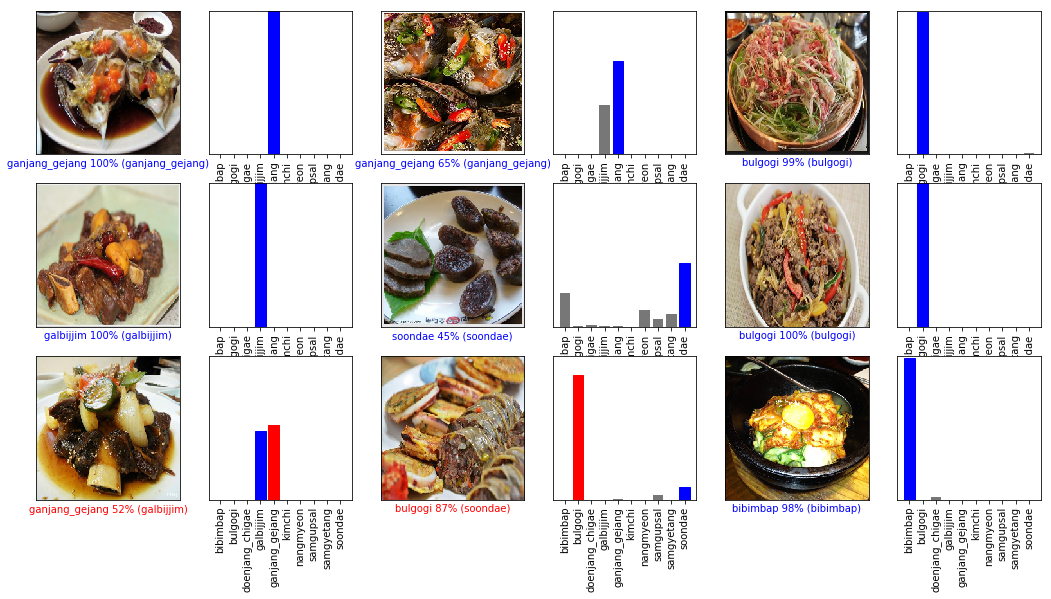

In [21]:
prob = tf.nn.softmax(logits)
imgs, lbs, x, y = sess.run([images, labels, image_post, label_onehot])
imgs = np.reshape(imgs, [-1, img_height, img_width, 3])
predictions = sess.run(prob, feed_dict={image_post:x, label_onehot:y, is_train:False})
num_rows = 3
num_cols = 3
num_images = num_rows*num_cols
plt.figure(figsize=(3*2*num_cols, 3*num_rows))
for i in range(num_images):
    plt.subplot(num_rows, 2*num_cols, 2*i+1)
    plot_image(i, predictions, lbs, imgs)
    plt.subplot(num_rows, 2*num_cols, 2*i+2)
    plot_value_array(i, predictions, lbs)